In [1]:
import pandas as pd
import numpy as np
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
from pyNBA.DFS.rules import FPCalculator
from pyNBA.DFS.constants import Site
from pyNBA.Data.constants import (ROTOWIRE_NAME_TO_NBA_NAME, LINESTARAPP_TEAM_TO_NBA_TEAM,
                                  LINESTARAPP_NAME_TO_NBA_NAME, OWNERSHIP_NAME_TO_NBA_NAME,
                                  BAD_CONTEST_SUBSTRINGS)

import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
query_data = QueryData(update=False)
clean_data = CleanData()

linestarapp_data = query_data.query_linestarapp_data()
linestarapp_data = linestarapp_data.loc[linestarapp_data['SITE'] == 'DRAFTKINGS']
linestarapp_data['PLAYER_NAME'] = linestarapp_data['PLAYER_NAME'].apply(
    lambda x: x if x not in LINESTARAPP_NAME_TO_NBA_NAME else LINESTARAPP_NAME_TO_NBA_NAME[x]
)
linestarapp_data['TEAM'] = linestarapp_data['TEAM'].apply(
    lambda x: x if x not in LINESTARAPP_TEAM_TO_NBA_TEAM else LINESTARAPP_TEAM_TO_NBA_TEAM[x]
)

rotowire_data = query_data.query_rotowire_data()
rotowire_data = rotowire_data.drop(columns=['TEAM', 'POS', 'G'])
rotowire_data['PLAYER_NAME'] = rotowire_data['PLAYER_NAME'].apply(
    lambda x: x if x not in ROTOWIRE_NAME_TO_NBA_NAME else ROTOWIRE_NAME_TO_NBA_NAME[x]
)

salary_data = query_data.query_salary_data()
salary_data = salary_data.loc[salary_data['SITE'] == 'DRAFTKINGS']
salary_data['POSITION'] = salary_data['POSITION'].apply(lambda x: x.replace('_', '/'))
salary_data['NAME'] = salary_data['PLAYER'].apply(clean_data.convert_rotoguru_name_to_nba_name)

boxscore_data = query_data.query_boxscore_data()

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


In [3]:
def _get_projection(roto_projection, linestar_projection):
    if np.isnan(roto_projection) and np.isnan(linestar_projection):
        return 0
    elif np.isnan(roto_projection):
        return linestar_projection
    elif np.isnan(linestar_projection):
        return roto_projection
    elif roto_projection == 0 and linestar_projection != 0:
        return linestar_projection
    elif roto_projection != 0 and linestar_projection == 0:
        return 0
    else:
        return roto_projection

linestarapp_data = linestarapp_data.loc[linestarapp_data['SITE'] == 'DRAFTKINGS']
linestarapp_data = linestarapp_data.rename(columns={'PROJECTION': 'LINESTARAPP_PROJECTION'})

rotowire_data['ROTOWIRE_PROJECTION'] = rotowire_data.apply(
    lambda row: FPCalculator.calculate_draftkings_fp(
        row['PTS'], row['REB'], row['AST'], row['TOV'], row['BLK'], row['STL'], row['THREEPM'], (row['DBLDBL'], row['TRPDBL'])
    ),
    axis=1
)
projections = linestarapp_data.merge(rotowire_data, on=['DATE', 'PLAYER_NAME'], how='left')
projections['PROJECTION'] = projections.apply(
    lambda row: _get_projection(row['ROTOWIRE_PROJECTION'], row['LINESTARAPP_PROJECTION']),
    axis=1
)

player_comments = boxscore_data[['DATE', 'NAME', 'COMMENT']]
player_comments = player_comments.rename(columns={'NAME': 'PLAYER_NAME'})
projections = projections.merge(player_comments, on=['DATE', 'PLAYER_NAME'], how='left')

projections = projections.loc[projections['DATE'].isin(set(boxscore_data['DATE'].unique()))]
projections = projections[[
    'DATE', 'SITE', 'PLAYER_ID', 'PLAYER_NAME', 'POS', 'TEAM', 'START', 'SPREAD', 'TOTAL',
    'OPPRANK_DvP_L20', 'OPPRANK_D_L20', 'PROJECTION', 'FINAL', 'COMMENT', 'LINESTARAPP_PROJECTION', 'ROTOWIRE_PROJECTION'
]]

projections

,DATE,SITE,PLAYER_ID,PLAYER_NAME,POS,TEAM,START,SPREAD,TOTAL,OPPRANK_DvP_L20,OPPRANK_D_L20,PROJECTION,FINAL,COMMENT,LINESTARAPP_PROJECTION,ROTOWIRE_PROJECTION
0,2015-10-27,DRAFTKINGS,138,Anderson Varejao,C,CLE,NaN,NaN,NaN,NaN,NaN,13.291550,6.50,,21.01,13.291550
1,2015-10-27,DRAFTKINGS,196,Earl Barron,C,ATL,NaN,NaN,NaN,NaN,NaN,6.640000,0.00,NaN,6.64,NaN
2,2015-10-27,DRAFTKINGS,396,Kendrick Perkins,C,NOP,NaN,NaN,NaN,NaN,NaN,18.150000,16.50,,18.15,NaN
3,2015-10-27,DRAFTKINGS,381,Alexis Ajinca,C,NOP,NaN,NaN,NaN,NaN,NaN,15.190000,10.50,,15.19,NaN
4,2015-10-27,DRAFTKINGS,211,Tiago Splitter,C,ATL,NaN,NaN,NaN,NaN,NaN,19.260000,11.00,,19.26,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238868,2021-05-16,DRAFTKINGS,889,Justin Jackson,PF,MIL,0.0,-7.5,224.5,8.0,12.0,0.000000,18.50,,0.00,NaN
238869,2021-05-16,DRAFTKINGS,1299,Jordan Nwora,PF,MIL,0.0,-7.5,224.5,8.0,12.0,0.000000,59.50,,0.00,0.000000
238870,2021-05-16,DRAFTKINGS,1377,Josh Hall,PF,OKC,1.0,8.0,220.5,19.0,4.0,10.515493,41.00,,7.53,10.515493
238871,2021-05-16,DRAFTKINGS,1207,Nicolo Melli,PF,DAL,0.0,-7.5,230.0,25.0,25.0,8.550000,22.25,,8.55,NaN


In [4]:
salaries = linestarapp_data.merge(
    salary_data,
    left_on=['SITE', 'DATE', 'PLAYER_NAME', 'POS'],
    right_on=['SITE', 'DATE', 'NAME', 'POSITION'],
    how='left',
    suffixes = ('_linestarrapp', '_rotoguru')
)

salaries = salaries.loc[salaries['DATE'].isin(set(boxscore_data['DATE'].unique()))]

salaries['SALARY'] = salaries[['SALARY_linestarrapp', 'SALARY_rotoguru']].min(axis=1)
salaries.loc[salaries['SALARY'] < 3000, 'SALARY'] = 3000
salaries = salaries[['DATE', 'SITE', 'PLAYER_ID', 'PLAYER_NAME', 'POS', 'TEAM', 'SALARY']]

salaries

,DATE,SITE,PLAYER_ID,PLAYER_NAME,POS,TEAM,SALARY
0,2015-10-27,DRAFTKINGS,138,Anderson Varejao,C,CLE,3400.0
1,2015-10-27,DRAFTKINGS,196,Earl Barron,C,ATL,3000.0
2,2015-10-27,DRAFTKINGS,396,Kendrick Perkins,C,NOP,3000.0
3,2015-10-27,DRAFTKINGS,381,Alexis Ajinca,C,NOP,3500.0
4,2015-10-27,DRAFTKINGS,211,Tiago Splitter,C,ATL,4500.0
...,...,...,...,...,...,...,...
238868,2021-05-16,DRAFTKINGS,889,Justin Jackson,PF,MIL,3000.0
238869,2021-05-16,DRAFTKINGS,1299,Jordan Nwora,PF,MIL,3000.0
238870,2021-05-16,DRAFTKINGS,1377,Josh Hall,PF,OKC,3000.0
238871,2021-05-16,DRAFTKINGS,1207,Nicolo Melli,PF,DAL,3000.0


In [18]:
df = projections.merge(
    salaries,
    on=['DATE', 'SITE', 'PLAYER_ID', 'PLAYER_NAME', 'POS', 'TEAM'],
    how='left'
)

season_dates = boxscore_data[['SEASON', 'DATE']].drop_duplicates()
df = df.merge(
    season_dates,
    on=['DATE'],
    how='left'
)
df = df.dropna(subset=['START'])

df = df.dropna(subset=['SALARY'])
df = df.loc[
    (df['PROJECTION'] != 0) |
    (df['COMMENT'] == '') |
    (df['COMMENT'].str.contains('coach', case=False))
]

pd.set_option('display.max_columns', None)
df[[
    'SEASON', 'DATE', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM', 'POS', 'SALARY', 'START',
    'SPREAD', 'TOTAL', 'OPPRANK_DvP_L20', 'OPPRANK_D_L20', 'PROJECTION', 'FINAL', 'COMMENT'
]].sort_values(by=['DATE', 'SALARY'], ascending=[True, False])

,SEASON,DATE,PLAYER_ID,PLAYER_NAME,TEAM,POS,SALARY,START,SPREAD,TOTAL,OPPRANK_DvP_L20,OPPRANK_D_L20,PROJECTION,FINAL,COMMENT
73139,2017-18,2017-10-17,126,LeBron James,CLE,SF/PF,10200.0,1.0,-4.5,216.0,30.0,19.0,50.203012,66.50,
73152,2017-18,2017-10-17,425,James Harden,HOU,SG,10000.0,1.0,9.5,230.5,22.0,9.0,50.292245,55.00,
73140,2017-18,2017-10-17,535,Kevin Durant,GSW,SF/PF,9600.0,1.0,-9.5,230.5,27.0,29.0,53.035150,41.75,
73161,2017-18,2017-10-17,296,Stephen Curry,GSW,PG,8800.0,1.0,-9.5,230.5,29.0,29.0,49.960242,36.75,
73162,2017-18,2017-10-17,125,Kyrie Irving,BOS,PG,8300.0,1.0,4.5,216.0,13.0,14.0,42.549822,50.50,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225894,2020-21,2021-05-16,889,Justin Jackson,MIL,PF,3000.0,0.0,-7.5,224.5,8.0,12.0,0.000000,18.50,
225895,2020-21,2021-05-16,1299,Jordan Nwora,MIL,PF,3000.0,0.0,-7.5,224.5,8.0,12.0,0.000000,59.50,
225896,2020-21,2021-05-16,1377,Josh Hall,OKC,PF,3000.0,1.0,8.0,220.5,19.0,4.0,10.515493,41.00,
225897,2020-21,2021-05-16,1207,Nicolo Melli,DAL,PF,3000.0,0.0,-7.5,230.0,25.0,25.0,8.550000,22.25,


In [19]:
from pyNBA.Models.features import FeatureCreation

feature_creation = FeatureCreation()

df['PROJECTION_DIFF'] = (df['ROTOWIRE_PROJECTION'] - df['LINESTARAPP_PROJECTION']).abs()
df.loc[
    (df['ROTOWIRE_PROJECTION'] == 0) |
    (df['LINESTARAPP_PROJECTION'] == 0),
    'PROJECTION_DIFF'
] = np.nan

df = feature_creation.expanding_mean(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='SALARY', new_col_name='AVG_SALARY'
)
df = feature_creation.lag(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='SALARY', new_col_name='L1_SALARY', n_shift=1
)
df['SALARY_CHANGE'] = df['SALARY'] - df['L1_SALARY']

df = feature_creation.expanding_mean(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='PROJECTION', new_col_name='AVG_PROJECTION'
)
df = feature_creation.lag(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='PROJECTION', new_col_name='L1_PROJECTION', n_shift=1
)
df['PROJECTION_CHANGE'] = df['PROJECTION'] - df['L1_PROJECTION']

df = feature_creation.expanding_standard_deviation(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='FINAL', new_col_name='STD_FP', min_periods=5
)

df = feature_creation.expanding_min(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='FINAL', new_col_name='MIN_FP'
)
df = feature_creation.expanding_max(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='FINAL', new_col_name='MAX_FP'
)

df['ABS_RES'] = (df['PROJECTION'] - df['FINAL']).abs()
df = feature_creation.expanding_mean(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='ABS_RES', new_col_name='AVG_ABS_RES'
)
df = feature_creation.lag(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='ABS_RES', new_col_name='L1_ABS_RES', n_shift=1
)

df['GP'] = 1
df = feature_creation.expanding_sum(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM'], col_name='GP', new_col_name='COUNT_GP'
)
df = feature_creation.expanding_sum(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM'], col_name='START', new_col_name='COUNT_START'
)
df['PCT_IN_ROLE'] = np.nan
df.loc[df['START'] == 1, 'PCT_IN_ROLE'] = df['COUNT_START']/df['COUNT_GP']
df.loc[df['START'] == 0, 'PCT_IN_ROLE'] = 1 - (df['COUNT_START']/df['COUNT_GP'])

In [20]:
regressors = [
    'PROJECTION_DIFF', 'SALARY', 'AVG_SALARY', 'SALARY_CHANGE', 'PROJECTION', 'AVG_PROJECTION', 'PROJECTION_CHANGE',
    'STD_FP', 'MIN_FP', 'MAX_FP', 'AVG_ABS_RES', 'L1_ABS_RES', 'START', 'COUNT_GP', 'PCT_IN_ROLE'
]
y = 'ABS_RES'

In [21]:
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = [
    xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist'),
    CatBoostRegressor(eval_metric='MAE', learning_rate=0.1, n_estimators=500, silent=True)
    
]

min_score = float('inf')
best_model = None
for model in models:
      
    # feature selection
    X = df[regressors]
    Y = df[y]

    model.fit(X, Y)

    # importance
    importance_selector = SelectFromModel(model, threshold='0.75*median')
    importance_selector = importance_selector.fit(X, Y)
    importance_support = importance_selector.get_support()

    # rank
    rank_selector = RFE(model)
    rank_selector = rank_selector.fit(X, Y)
    rank_support = rank_selector.ranking_
    median_rank = np.median(rank_support)

    selected_features = []
    for feature, importance_flag, rank in zip(list(X.columns), importance_support, rank_support):
        # select the feature if it's important, or has a low rank
        if importance_flag or (rank <= median_rank):
            selected_features.append(feature)

    X = df[selected_features].values
    Y = df[y].values

    # cross validation
    scores = []
    cv = KFold(n_splits=5, shuffle=True)
    for train, test in cv.split(X, Y):
        prediction = model.fit(X[train], Y[train]).predict(X[test])
        true = Y[test]

        scores.append(mean_absolute_error(prediction, true))

    mean_score = np.mean(scores)
    print('\nModel:', model)
    print('Selected Features:', selected_features)
    print('Mean MAE:', mean_score)
    if mean_score < min_score:
        min_score = mean_score
        best_model = (model, selected_features)

print()
print(best_model, min_score)


Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='hist', validate_parameters=1, verbosity=None)
Selected Features: ['PROJECTION_DIFF', 'SALARY', 'AVG_SALARY', 'SALARY_CHANGE', 'PROJECTION', 'AVG_PROJECTION', 'PROJECTION_CHANGE', 'STD_FP', 'MIN_FP', 'MAX_FP', 'AVG_ABS_RES', 'L1_ABS_RES', 'START', 'COUNT_GP', 'PCT_IN_ROLE']
Mean MAE: 4.355646941725636

Model: <catboost.core.CatBoostRegressor object at 0x7f9daa3cb8b0>
Selected Features: ['PROJECTION_DIFF', 'SALARY', 'AVG_SALARY', 'PROJECTION', 'AVG_PRO

In [22]:
selected_features = [
    'PROJECTION_DIFF', 'SALARY', 'AVG_SALARY', 'PROJECTION', 'AVG_PROJECTION', 'PROJECTION_CHANGE',
    'STD_FP', 'MIN_FP', 'MAX_FP', 'AVG_ABS_RES', 'L1_ABS_RES', 'START', 'COUNT_GP', 'PCT_IN_ROLE'
]
X = df[selected_features]
Y = df[y]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

In [23]:
model = xgb.XGBRegressor()

model_params = {
    'max_depth': [6, 8, 10],
    'eta' : [0.01, 0.02, 0.05],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'n_estimators': [2000],
    'eval_metric': ['mae'],
    'tree_method': ['hist']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 25,
    "eval_set": [(X_test, y_test)]
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

[0]	validation_0-mae:6.31605
[1]	validation_0-mae:6.26381
[2]	validation_0-mae:6.21274
[3]	validation_0-mae:6.16279
[4]	validation_0-mae:6.11386
[5]	validation_0-mae:6.06607
[6]	validation_0-mae:6.01921
[7]	validation_0-mae:5.97346
[8]	validation_0-mae:5.92903
[9]	validation_0-mae:5.88569
[10]	validation_0-mae:5.84312
[11]	validation_0-mae:5.80165
[12]	validation_0-mae:5.76113
[13]	validation_0-mae:5.72176
[14]	validation_0-mae:5.68318
[15]	validation_0-mae:5.64535
[16]	validation_0-mae:5.60854
[17]	validation_0-mae:5.57244
[18]	validation_0-mae:5.53717
[19]	validation_0-mae:5.50272
[20]	validation_0-mae:5.46903
[21]	validation_0-mae:5.43621
[22]	validation_0-mae:5.40388
[23]	validation_0-mae:5.37252
[24]	validation_0-mae:5.34192
[25]	validation_0-mae:5.31204
[26]	validation_0-mae:5.28263
[27]	validation_0-mae:5.25410
[28]	validation_0-mae:5.22626
[29]	validation_0-mae:5.19911
[30]	validation_0-mae:5.17271
[31]	validation_0-mae:5.14678
[32]	validation_0-mae:5.12131
[33]	validation_0-ma

In [24]:
best_params = grid.best_params_
model = xgb.XGBRegressor(**best_params)

model.fit(X_train, y_train, **fit_params)

y_hat = model.predict(X_test)

[0]	validation_0-mae:6.31605
[1]	validation_0-mae:6.26381
[2]	validation_0-mae:6.21274
[3]	validation_0-mae:6.16279
[4]	validation_0-mae:6.11386
[5]	validation_0-mae:6.06607
[6]	validation_0-mae:6.01921
[7]	validation_0-mae:5.97346
[8]	validation_0-mae:5.92903
[9]	validation_0-mae:5.88569
[10]	validation_0-mae:5.84312
[11]	validation_0-mae:5.80165
[12]	validation_0-mae:5.76113
[13]	validation_0-mae:5.72176
[14]	validation_0-mae:5.68318
[15]	validation_0-mae:5.64535
[16]	validation_0-mae:5.60854
[17]	validation_0-mae:5.57244
[18]	validation_0-mae:5.53717
[19]	validation_0-mae:5.50272
[20]	validation_0-mae:5.46903
[21]	validation_0-mae:5.43621
[22]	validation_0-mae:5.40388
[23]	validation_0-mae:5.37252
[24]	validation_0-mae:5.34192
[25]	validation_0-mae:5.31204
[26]	validation_0-mae:5.28263
[27]	validation_0-mae:5.25410
[28]	validation_0-mae:5.22626
[29]	validation_0-mae:5.19911
[30]	validation_0-mae:5.17271
[31]	validation_0-mae:5.14678
[32]	validation_0-mae:5.12131
[33]	validation_0-ma

<AxesSubplot:xlabel='Feature'>

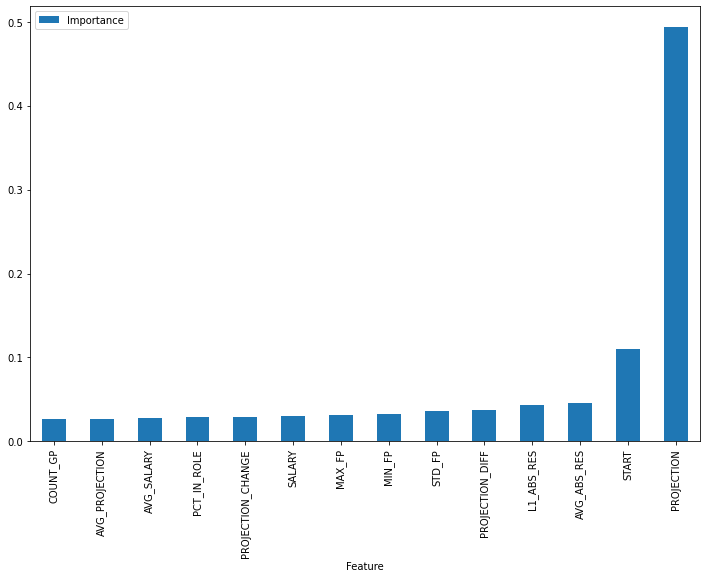

In [25]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
feature_importance_df.plot.bar(x='Feature', y='Importance', figsize=(12, 8))

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_avg = df.loc[X_test.index, 'AVG_ABS_RES'].fillna(df['ABS_RES'])

# Kpi
print("R2 (explained variance):")
print("Model:", round(r2_score(y_test, y_hat), 3))
print("Baseline:", round(r2_score(y_test, y_avg), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(mean_absolute_error(y_test, y_hat), 6))
print("Baseline:", round(mean_absolute_error(y_test, y_avg), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(mean_squared_error(y_test, y_hat)), 6))
print("Baseline:", round(np.sqrt(mean_squared_error(y_test, y_avg)), 6))

R2 (explained variance):
Model: 0.098
Baseline: 0.067

Mean Absolute Error (Σ|y-pred|/n):
Model: 4.202594
Baseline: 4.37939

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 5.879137
Baseline: 5.977438


No handles with labels found to put in legend.
No handles with labels found to put in legend.


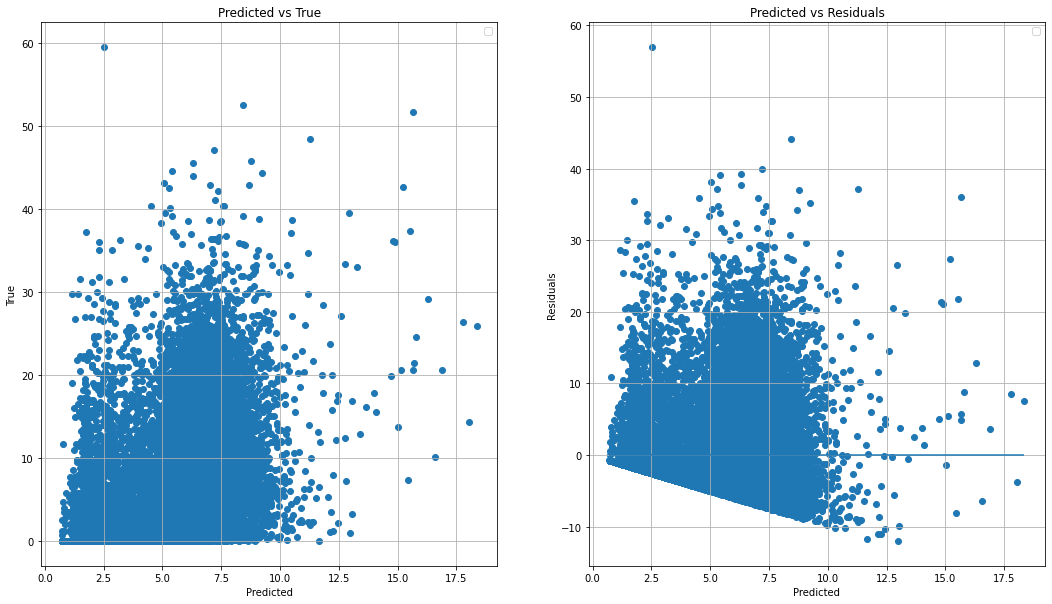

In [27]:
import matplotlib.pyplot as plt

residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
ax[0].scatter(y_hat, y_test)
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
ax[1].scatter(y_hat, residuals)
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

In [28]:
temp = df.copy()
temp.loc[X_test.index, 'ABS_RES_HAT'] = y_hat
temp.sort_values(by='ABS_RES_HAT', ascending=False)

,SITE,PLAYER_ID,PLAYER_NAME,DATE,POS,TEAM,START,SPREAD,TOTAL,OPPRANK_DvP_L20,OPPRANK_D_L20,PROJECTION,FINAL,COMMENT,LINESTARAPP_PROJECTION,ROTOWIRE_PROJECTION,SALARY,SEASON,PROJECTION_DIFF,AVG_SALARY,L1_SALARY,SALARY_CHANGE,AVG_PROJECTION,L1_PROJECTION,PROJECTION_CHANGE,STD_FP,MIN_FP,MAX_FP,ABS_RES,AVG_ABS_RES,L1_ABS_RES,GP,COUNT_GP,COUNT_START,PCT_IN_ROLE,ABS_RES_HAT
73088,DRAFTKINGS,1140,Sekou Doumbouya,2020-01-02,SF/PF,DET,1.0,12.5,224.5,17.0,16.0,1.324980,27.25,,1.04,1.324980,3000.0,2019-20,0.284980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.925020,NaN,NaN,1,10.0,0.0,0.000000,18.364361
8530,DRAFTKINGS,296,Stephen Curry,2017-12-04,PG/SG,GSW,1.0,-9.0,228.0,11.0,22.0,44.420000,58.75,,44.42,0.000000,9400.0,2017-18,NaN,9195.454545,9400.0,0.0,4.710821e+01,43.067542,1.352458,8.109605,31.00,69.25,14.330000,6.662623e+00,0.432458,1,22.0,22.0,1.000000,18.058653
62001,DRAFTKINGS,512,Karl-Anthony Towns,2019-10-30,C,MIN,1.0,7.0,222.5,1.0,2.0,54.360000,28.00,,54.36,0.000000,9900.0,2019-20,NaN,10333.333333,10100.0,-200.0,5.438157e+01,52.151855,2.208145,NaN,51.25,82.25,26.360000,1.521967e+01,0.901855,1,3.0,3.0,1.000000,17.783545
62255,DRAFTKINGS,1044,Luka Doncic,2019-11-01,PG/SG,DAL,1.0,0.0,218.5,20.0,14.0,54.710000,75.25,,54.71,0.000000,9700.0,2019-20,NaN,9400.000000,9500.0,200.0,5.000453e+01,47.759667,6.950333,NaN,27.00,64.00,20.540000,1.156280e+01,20.759667,1,4.0,4.0,1.000000,16.890528
35558,DRAFTKINGS,63,Joel Embiid,2018-11-16,C,PHI,1.0,-2.5,216.5,27.0,7.0,54.870000,44.75,,54.87,0.000000,10300.0,2018-19,NaN,10518.750000,10500.0,-200.0,5.419626e+01,60.027263,-5.157263,13.167026,28.50,79.00,10.120000,1.112853e+01,0.277263,1,16.0,16.0,1.000000,16.578554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114478,DRAFTKINGS,43,Thanasis Antetokounmpo,2021-05-16,PF,MIL,0.0,-7.5,224.5,8.0,12.0,1.709422,4.25,,3.28,1.709422,3000.0,2020-21,1.570577,3086.956522,3000.0,0.0,5.219907e+00,0.000000,1.709422,6.152905,-0.50,23.75,2.540578,4.301205e+00,1.500000,1,71.0,2.0,0.971831,NaN
114479,DRAFTKINGS,889,Justin Jackson,2021-05-16,PF,MIL,0.0,-7.5,224.5,8.0,12.0,0.000000,18.50,,0.00,NaN,3000.0,2020-21,NaN,3000.000000,3000.0,0.0,1.065814e-14,0.000000,0.000000,0.000000,0.00,0.00,18.500000,3.552714e-15,0.000000,1,8.0,0.0,1.000000,NaN
114481,DRAFTKINGS,1377,Josh Hall,2021-05-16,PF,OKC,1.0,8.0,220.5,19.0,4.0,10.515493,41.00,,7.53,10.515493,3000.0,2020-21,2.985493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.484507,NaN,NaN,1,30.0,0.0,0.000000,NaN
114482,DRAFTKINGS,1207,Nicolo Melli,2021-05-16,PF,DAL,0.0,-7.5,230.0,25.0,25.0,8.550000,22.25,,8.55,NaN,3000.0,2020-21,NaN,3083.333333,3000.0,0.0,5.800833e+00,5.380000,3.170000,6.365162,0.00,19.00,13.700000,5.788750e+00,7.620000,1,28.0,4.0,0.857143,NaN
